In [54]:
import tensorflow as tf

In [55]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

In [70]:
RUN             = '5'
EPOCHS          = 40

seeds           = {'1':512, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

conditional     = False
cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.05
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div'

plotpath        = '/global/homes/v/vboehm/codes/SDSS_PAE/figures'

if conditional:
    label_2='conditional_%s'%cond_on+label_2
    
data_path       = '/global/cscratch1/sd/vboehm/SDSSOutlier/fc'

In [71]:
tf.__version__
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [72]:
train = pickle.load(open(os.path.join(root_model_data,'SDSS_DR16_preprocessed_train.pkl'),'rb'))
valid = pickle.load(open(os.path.join(root_model_data,'SDSS_DR16_preprocessed_test.pkl'),'rb'))

In [73]:
path = os.path.join(root_models,'encoder_%s_run%s_new'%(label_2, RUN))
encoder = tf.keras.models.load_model(path)
path = os.path.join(root_models,'decoder_%s_run%s_new'%(label_2, RUN))
decoder = tf.keras.models.load_model(path)

In [74]:
encoded_train = encoder.predict(train['spec'])
encoded_valid = encoder.predict(valid['spec'])

In [75]:
decoded_train = decoder.predict(encoded_train)
decoded_valid = decoder.predict(encoded_valid)

In [76]:
np.save(os.path.join(data_path,'encoded_fc_5.npy'),[np.squeeze(encoded_train), np.squeeze(encoded_valid)])

In [77]:
np.save(os.path.join(data_path,'decoded_fc_5.npy'),[np.squeeze(decoded_train), np.squeeze(decoded_valid)])

In [78]:
def loss_by_wl(y_true, y_pred):
    loss           = (y_true[0]-y_pred)**2*y_true[2]*y_true[1]
    valid_loss     = np.mean(loss,axis=0)
    std_valid_loss = np.std(loss,axis=0)
    return valid_loss, std_valid_loss

In [79]:
loss = loss_by_wl((valid['spec'],valid['mask'],valid['noise']),np.expand_dims(decoded_valid,-1))

In [80]:
wlmin, wlmax    = (3388,8318)
wl_range        = (np.log10(wlmin),np.log10(wlmax))
new_wl          = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

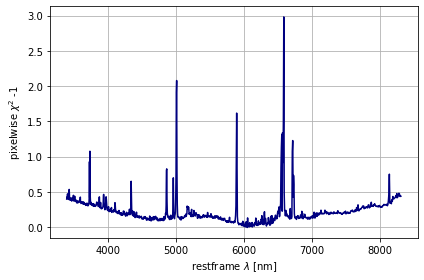

In [81]:
plt.plot(new_wl[:-1],loss[0]/np.mean(valid['mask'],axis=0)-1,color='navy')
plt.xlabel(r'restframe $\lambda$ [nm]')
plt.ylabel('pixelwise $\chi^2$ -1')
plt.grid()
plt.tight_layout()

In [82]:
print('mean reconstruction loss:', np.mean(loss[0]/np.mean(valid['mask'])))

mean reconstruction loss: 1.2223667402172522


In [83]:
np.save(os.path.join(data_path,'mean_loss_fc_5.npy'),loss[0])